<h3>OSIC Pulmonary Fibrosis Progression<h3>

https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression

In [2]:
import os
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom

import Function 

In [3]:
df_train= pd.read_csv("train.csv")
df_test= pd.read_csv("test.csv")

In [4]:
df_test

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [5]:
df_train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [7]:
Patient_list= df_train["Patient"].unique()

In [8]:
def getDcms(patient):
    image_dir = 'train/'+patient
    fig=plt.figure(figsize=(10,10))
    image_list = os.listdir(image_dir)
    columns = int(np.sqrt(len(image_list)))
    rows = columns+1
    dcms=[]
    for i in range(1, len(image_list) +1):
        ds = pydicom.dcmread(image_dir + "/" + str(i) + ".dcm")
        dcms.append(ds.pixel_array)
        fig.add_subplot(rows,columns,i)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    return dcms

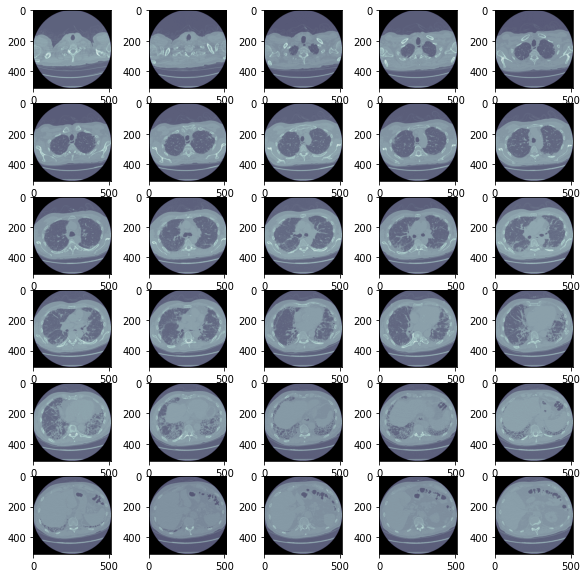

In [9]:
list=getDcms(Patient_list[0])

In [10]:
list[0].shape

(512, 512)

In [11]:
list[0]

array([[-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       ...,
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000]], dtype=int16)